<a href="https://colab.research.google.com/github/MarkovChainMC/PINN/blob/main/PINN_for_Poisson_and_Analytical_Check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

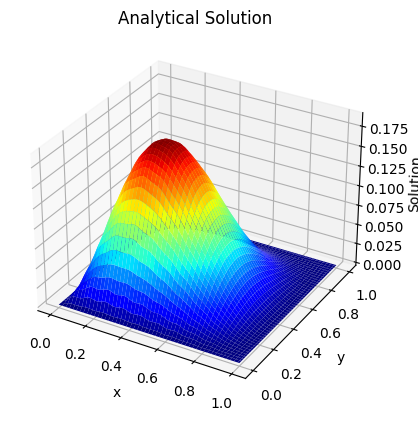

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define the domain boundaries
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0

# Define the number of modes for the eigenfunction expansion
m_max, n_max = 20, 20

# Define the length of the domain along x and y directions
L_x, L_y = x_max - x_min, y_max - y_min

# Define the source function (you can modify this according to your problem)
def source(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

# Compute the analytical solution
def analytical_solution(x, y, m_max, n_max):
    u = np.zeros_like(x)
    for m in range(1, m_max + 1):
        for n in range(1, n_max + 1):
            eigenvalue = (m * np.pi / L_x) ** 2 + (n * np.pi / L_y) ** 2
            eigenfunction = np.sin(m * np.pi * x / L_x) * np.sin(n * np.pi * y / L_y)
            coefficient = 4 / (L_x * L_y) * source(x, y) / eigenvalue
            u += coefficient * eigenfunction
    return u

# Create a meshgrid for the x and y coordinates
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Compute the analytical solution on the grid
u_analytical = analytical_solution(x_grid, y_grid, m_max, n_max)

# Create the 3D plot using plot_surface from matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, u_analytical, cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Solution')
ax.set_title('Analytical Solution')

plt.show()


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
# Define the domain boundaries
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0

# Define the interior region (e.g., a rectangle)
x_interior_min, x_interior_max = 0.05, 0.95
y_interior_min, y_interior_max = 0.05, 0.95

# Define the exterior region (complement of the interior region)
x_exterior_min, x_exterior_max = x_min, x_max
y_exterior_min, y_exterior_max = y_min, y_max

# Define the number of interior and boundary points
num_interior_points = 1000
num_boundary_points = 100

In [5]:
# Generate interior points
x_interior = np.random.uniform(x_interior_min, x_interior_max, num_interior_points)
y_interior = np.random.uniform(y_interior_min, y_interior_max, num_interior_points)

# Generate boundary points
x_boundary = np.concatenate([np.linspace(x_min, x_max, num_boundary_points),
                             np.linspace(x_min, x_max, num_boundary_points),
                             np.full(num_boundary_points, x_min),
                             np.full(num_boundary_points, x_max)])
y_boundary = np.concatenate([np.full(num_boundary_points, y_min),
                             np.full(num_boundary_points, y_max),
                             np.linspace(y_min, y_max, num_boundary_points),
                             np.linspace(y_min, y_max, num_boundary_points)])
x_interior = tf.convert_to_tensor(x_interior, dtype=tf.float32)
y_interior = tf.convert_to_tensor(y_interior, dtype=tf.float32)
x_boundary = tf.convert_to_tensor(x_boundary, dtype=tf.float32)
y_boundary = tf.convert_to_tensor(y_boundary, dtype=tf.float32)

In [6]:

# Define the neural network architecture
class NeuralNetwork(tf.keras.Model):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation="relu")
        self.dense2 = tf.keras.layers.Dense(32, activation="relu")
        self.dense3 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return x


# Create an instance of the model
model = NeuralNetwork()

In [7]:
# Define the source function
def source(x, y):
    return tf.sin(x) * tf.sin(y)


In [8]:
def custom_loss(x_interior, y_interior, x_boundary, y_boundary, model):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_interior)
        tape.watch(y_interior)

        # Compute the predicted solution for interior points
        u_pred_interior = model(tf.stack([x_interior, y_interior], axis=1))

        # Compute the gradients of u_pred_interior with respect to x_interior and y_interior
        u_gradients = tape.gradient(u_pred_interior, [x_interior, y_interior])
        u_x, u_y = u_gradients[0], u_gradients[1]

        # Compute the gradients of u_x with respect to x_interior
        u_xx = tape.gradient(u_x, x_interior)

        # Compute the gradients of u_y with respect to y_interior
        u_yy = tape.gradient(u_y, y_interior)

    # Compute the residual loss using the Poisson equation
    residual_loss = tf.reduce_mean(tf.square(u_xx + u_yy - source(x_interior, y_interior)))

    # Compute the predicted solution for boundary points
    u_pred_boundary = model(tf.stack([x_boundary, y_boundary], axis=1))

    # Compute the boundary loss using the Dirichlet boundary condition
    boundary_loss = tf.reduce_mean(tf.square(u_pred_boundary - 0.0))

    # Compute the total loss
    total_loss = residual_loss + boundary_loss

    return total_loss, u_pred_interior

In [10]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Define the number of training iterations
num_iterations = 1000

# Lists to store the loss values and predicted solutions
loss_history = []

# Training loop for the PINN model
for iteration in range(num_iterations):
    with tf.GradientTape() as tape:
        # Compute the loss and the predicted solution
        loss, u_pred_interior = custom_loss(x_interior, y_interior, x_boundary, y_boundary, model)
        loss_history.append(loss)

    # Compute the gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    # Update the model parameters
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


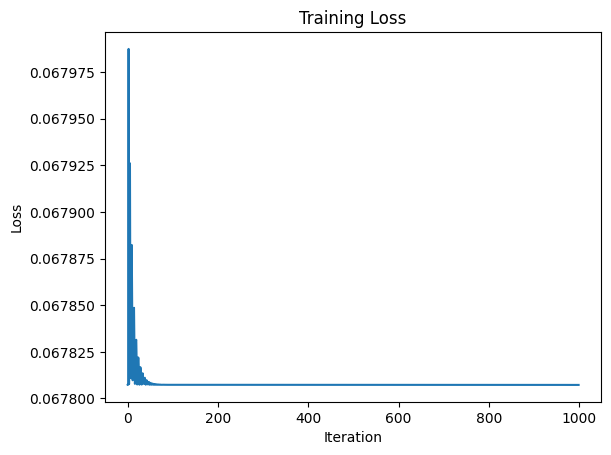

In [11]:
# Plot the loss history

plt.figure()
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [12]:
# Plot the predicted solution
# Create a meshgrid for the x and y coordinates
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))
num_points = 50

# Flatten the grid coordinates
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Convert the grid coordinates to tensors
x_grid_tensor = tf.convert_to_tensor(x_flat, dtype=tf.float32)
y_grid_tensor = tf.convert_to_tensor(y_flat, dtype=tf.float32)

# Compute the predicted solution for all grid points
grid_points = tf.stack([x_grid_tensor, y_grid_tensor], axis=1)
u_pred_grid = model(grid_points)

# Reshape the predicted solution to match the shape of the grid
z_grid = tf.reshape(u_pred_grid, (num_points, num_points)).numpy()

# Create the 3D surface plot using Plotly
fig = go.Figure(data=[go.Surface(x=x_grid, y=y_grid, z=z_grid, colorscale='jet')])
fig.update_layout(title='Predicted Solution', autosize=False, width=500, height=500)
fig.show()
